# Counties modelling

## Model then push forward

This script proceeds in three steps:

1. Fit a county-level model of infogroup bias reduction using 2010 data
2. Project the model to all available years 
3. Check performance against ACS one-year estimates for counties that have this

---

### Setup

In [2]:
# load packages
suppressPackageStartupMessages({
    library(tidyverse)
    library(lme4)
    library(brms)
    library(extrafont)
    library(parallel)
    library(patchwork)
    library(visdat)
    library(gtools)
    library(ggridges)
})

In [3]:
# read in modelling help functions
source("../functions/utils.R")

In [4]:
# read in data
dec <- readRDS("../data/prepped_data/counties_decennial.rds")
acs_1 <- readRDS("../data/prepped_data/counties_1_acs.rds")
acs_5 <- readRDS("../data/prepped_data/counties_5_acs.rds")

In [5]:
names(dec) <- sub("_$", "", names(dec))
names(acs_1) <- sub("_$", "", names(acs_1))
names(acs_5) <- sub("_$", "", names(acs_5))

In [6]:
mean(acs_1$chh)
sd(acs_1$chh)
min(acs_1$chh)
max(acs_1$chh)

[1] 124285.3

[1] 201815.5

[1] 16510

[1] 3313908

In [7]:
n_cores <- detectCores() - 1
n_cores

[1] 7

---

### Fit Model

In [8]:
# Formulas
desc1 <- "infogroup only"
f1 <- formula(log(chh) ~ log(ig_count_imptd))

desc2 <- "+ state FE"
f2 <- update(f1, ~ . + as.factor(stateid))

desc3 <- "+ covariates"
f3 <- update(f2, ~ . + pown + pfemale + page_1824 + page_under18 + 
             page_65plus + pnw + pblack + phisp + pasian + pnative +
             pvacant + phu_othervacant + pgq)

desc4 <- "Bayesian random slopes model"
f4 <- formula(log(chh) ~ 1 + log(ig_count_imptd) + (1 + log(ig_count_imptd) | stateid) +
             pown + pfemale + page_1824 + page_under18 + page_65plus + pnw + pblack + 
             phisp + pasian + pnative + pvacant + phu_othervacant + pgq)


formulas <- list(f1, f2, f3, f4)

In [9]:
# Set Bayesian priors here
my_prior <- c(
    set_prior("normal(0, 5)", class = "Intercept"),
    set_prior("normal(0, 5)", class = "b"),
    set_prior("student_t(3, 0, 5)", class = "sd"),
    set_prior("lkj(2)", class = "cor")
)

In [10]:
# STAN model
print(make_stancode(f4, dec, prior = my_prior))

// generated with brms 2.14.4
functions {
  /* turn a vector into a matrix of defined dimension 
   * stores elements in row major order
   * Args: 
   *   X: a vector 
   *   N: first dimension of the desired matrix
   *   K: second dimension of the desired matrix 
   * Returns: 
   *   a matrix of dimension N x K 
   */ 
  matrix as_matrix(vector X, int N, int K) { 
    matrix[N, K] Y; 
    for (i in 1:N) {
      Y[i] = to_row_vector(X[((i - 1) * K + 1):(i * K)]); 
    }
    return Y; 
  } 
 /* compute correlated group-level effects
  * Args: 
  *   z: matrix of unscaled group-level effects
  *   SD: vector of standard deviation parameters
  *   L: cholesky factor correlation matrix
  * Returns: 
  *   matrix of scaled group-level effects
  */ 
  matrix scale_r_cor(matrix z, vector SD, matrix L) {
    // r is stored in another dimension order than z
    return transpose(diag_pre_multiply(SD, L) * z);
  }
}
data {
  int<lower=1> N;  // total number of observations
  vector[N] Y;  // r

In [11]:
# Custom function for fitting multiple models
# See ~functions/utils.R
# Path saves Bayesian models so they don't have to be rerun
models <- fit_models(
    formulas, 
    dec, 
    "../models/county/final_model_county.rds",
    chains = 4,
    iter = 4000,
    warmup = 1000,
    thin = 2,
    prior = my_prior,
    cores = n_cores
)

Fitting model 1

Model fit complete. Runtime:  0.001771927

Fitting model 2

Model fit complete. Runtime:  0.008121014

Fitting model 3

Model fit complete. Runtime:  0.01174092

Fitting model 4

Model fit complete. Runtime:  0.245316

In [12]:
summary(models[[4]])

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: log(chh) ~ 1 + log(ig_count_imptd) + (1 + log(ig_count_imptd) | stateid) + pown + pfemale + page_1824 + page_under18 + page_65plus + pnw + pblack + phisp + pasian + pnative + pvacant + phu_othervacant + pgq 
   Data: data (Number of observations: 3142) 
Samples: 4 chains, each with iter = 4000; warmup = 1000; thin = 2;
         total post-warmup samples = 6000

Group-Level Effects: 
~stateid (Number of levels: 51) 
                                 Estimate Est.Error l-95% CI u-95% CI Rhat
sd(Intercept)                        0.29      0.04     0.22     0.36 1.00
sd(logig_count_imptd)                0.03      0.00     0.02     0.04 1.00
cor(Intercept,logig_count_imptd)    -0.98      0.01    -0.99    -0.95 1.00
                                 Bulk_ESS Tail_ESS
sd(Intercept)                        2686     3940
sd(logig_count_imptd)                2737     4145
cor(Intercept,logig_count_imptd)     2790     4287

Popula

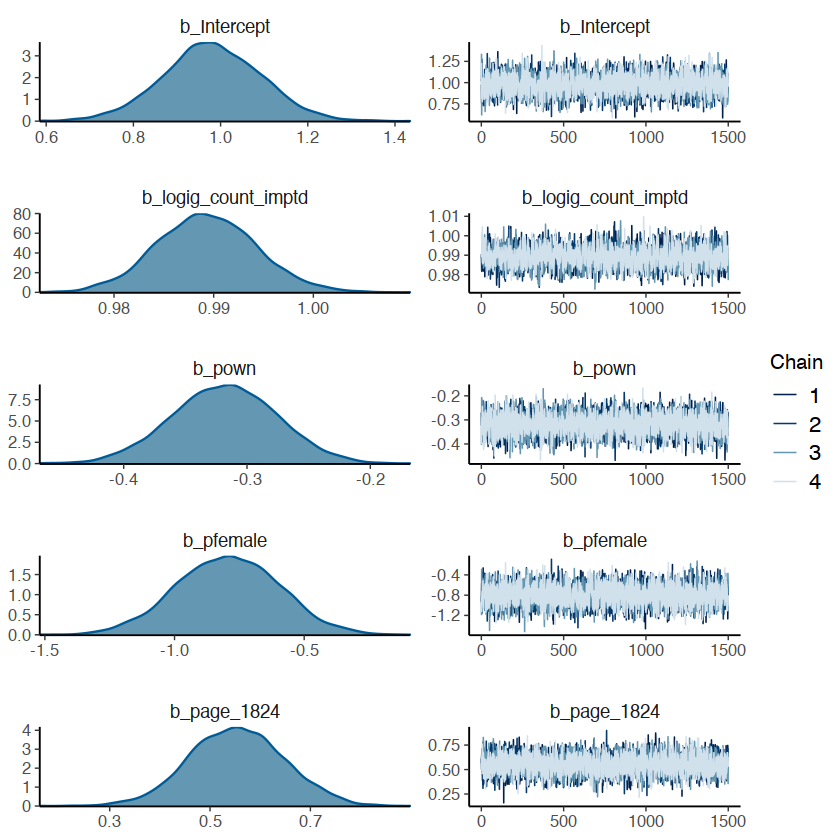

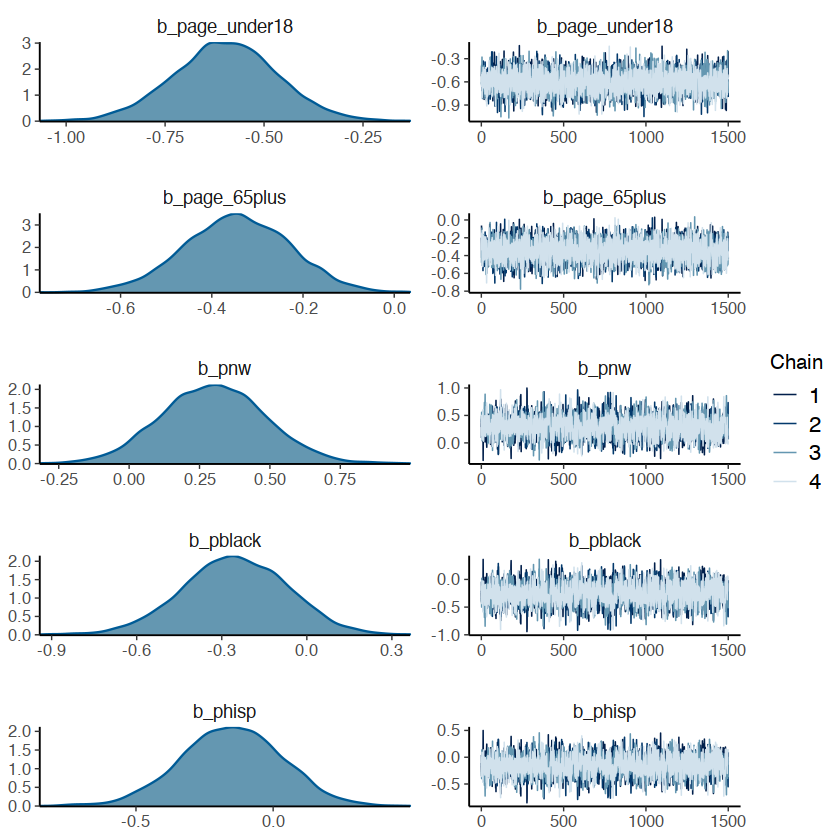

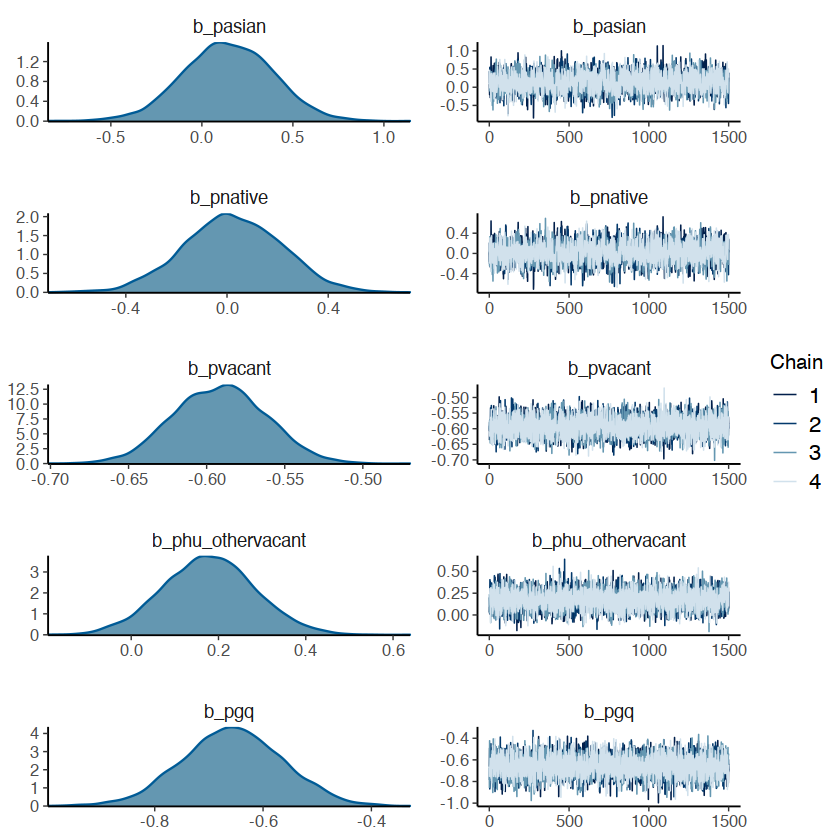

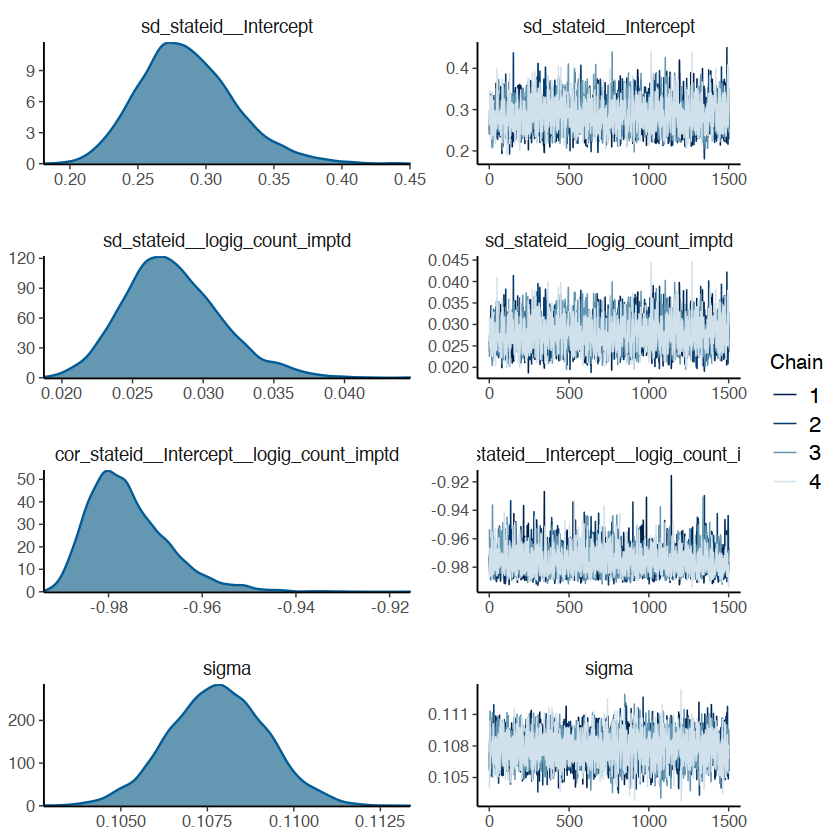

In [13]:
plot(models[[4]])

--- 

### Checking in-sample errors

In [14]:
results <- get_preds(models, dec, n_samples = 5000)
head(results)

countyid,year,ig_count,missing,lead,lag,ig_count_imptd,area_sqmi,geoid,chh,⋯,ll95_3,prd_3,u95_3,l95_3,lprd_4,lu90_4,ll90_4,prd_4,u90_4,l90_4
<chr>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
02013,2010,561,FALSE,585,564,561,6981.9400,2013,553,⋯,6.339736,595.6898,596.7411,594.6386,6.370702,6.456784,6.285064,584.4681,637.0089,536.4986
02016,2010,624,FALSE,609,626,624,4390.2740,2016,1212,⋯,6.456901,664.3296,665.3724,663.2868,6.464079,6.537264,6.390660,641.6728,690.3953,596.2497
02020,2010,101759,FALSE,102863,102246,101759,1704.6820,2020,107332,⋯,11.534229,104673.7718,104674.7965,104672.7472,11.633009,11.710181,11.551972,112759.0602,121805.5149,103981.9067
02050,2010,4199,FALSE,4277,4240,4199,40569.9800,2050,4651,⋯,8.416881,4656.4717,4657.5013,4655.4421,8.498740,8.543205,8.453881,4908.5798,5131.7659,4693.2510
02060,2010,574,FALSE,588,582,574,503.8427,2060,423,⋯,6.292027,557.0715,558.1026,556.0403,6.256183,6.315746,6.198003,521.2258,553.2148,491.7660
02068,2010,947,FALSE,950,987,947,12751.4100,2068,806,⋯,6.536685,708.4002,709.4268,707.3735,6.560650,6.609980,6.513352,706.7307,742.4684,674.0820


In [15]:
log_errors <- rbind(
  get_errors(log(results$chh), log(results$ig_count_imptd), "raw infogroup"),
  get_errors(log(results$chh), results$lprd_1, desc1),
  get_errors(log(results$chh), results$lprd_2, desc2),
  get_errors(log(results$chh), results$lprd_3, desc3),
  get_errors(log(results$chh), results$lprd_4, desc4)
)
log_errors

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
raw infogroup,9.326567,1.442821,9.277434,1.424392,0.9945549,0.9891395,0.1585156,0.10712737,0.08125143
infogroup only,9.326567,1.442821,9.326567,1.434965,0.9945549,0.9891395,0.1503377,0.09475847,0.06422894
+ state FE,9.326567,1.442821,9.326567,1.436658,0.9957284,0.9914751,0.1331948,0.07904656,0.05357521
+ covariates,9.326567,1.442821,9.326567,1.438470,0.9969848,0.9939787,0.1119406,0.06368838,0.04215067
Bayesian random slopes model,9.326567,1.442821,9.326573,1.438746,0.9972915,0.9945904,0.1061030,0.06139206,0.03978890


In [16]:
errors <- rbind(
  get_errors(results$chh, results$ig_count_imptd, "raw infogroup"),
  get_errors(results$chh, results$prd_1, desc1),
  get_errors(results$chh, results$prd_2, desc2),
  get_errors(results$chh, results$prd_3, desc3),
  get_errors(results$chh, results$prd_4, desc4)
)
errors

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
raw infogroup,37147.05,111990.8,33480.61,93072.21,0.9952227,0.9904682,21697.911,4286.727,702.0000
infogroup only,37147.05,111990.8,35788.12,100919.02,0.9956221,0.9912634,14943.822,3030.416,587.5838
+ state FE,37147.05,111990.8,36412.64,108895.39,0.9977698,0.9955445,8030.993,2141.798,483.4632
+ covariates,37147.05,111990.8,36725.05,109970.12,0.9985702,0.9971424,6282.276,1638.136,404.0624
Bayesian random slopes model,37147.05,111990.8,36801.77,110585.69,0.9980503,0.9961045,7097.105,1605.355,388.2764


---

### Use model to project to all years

Here we're working off the ACS one-year, so we project only to the counties in this file

In [20]:
# Custom function runs predictions for every model, for every year
projections <- proj_by_year(acs_1, dec, models, "countyid", n_samples = 5000)

predictions for 2006

predictions for 2007

predictions for 2008

predictions for 2009

predictions for 2010

predictions for 2011

predictions for 2012

predictions for 2013

predictions for 2014

predictions for 2015

predictions for 2016

predictions for 2017

predictions for 2018



In [21]:
head(projections)

countyid,year,ig_count_imptd,chh,chh_moe,ig_count,missing,lead,lag,area_sqmi,⋯,ll95_3,prd_3,u95_3,l95_3,lprd_4,lu90_4,ll90_4,prd_4,u90_4,l90_4
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
02020,2006,112860,102282,1569,101759,FALSE,102863,102246,1704.6820,⋯,11.63595,115885.53,115886.56,115884.51,11.73739,11.81662,11.65536,125164.89,135485.99,115307.65
02090,2006,37653,27986,1148,34680,FALSE,35084,34740,7338.2060,⋯,10.49142,36892.40,36893.43,36891.38,10.58351,10.64255,10.52372,39478.42,41879.24,37187.24
02170,2006,31888,21610,695,31002,FALSE,31619,30730,24607.8900,⋯,10.14738,26178.14,26179.17,26177.12,10.24220,10.29857,10.18445,28062.83,29690.03,26487.99
01003,2006,68214,70427,2608,77315,FALSE,77636,70954,1589.7830,⋯,10.98983,60211.35,60212.37,60210.34,11.04422,11.08120,11.00628,62581.09,64938.77,60251.53
01015,2006,44198,46503,1424,44117,FALSE,42200,41884,605.8674,⋯,10.70950,45418.39,45419.41,45417.38,10.74821,10.77806,10.71801,46546.55,47956.76,45161.78
01043,2006,30827,30953,1300,30658,FALSE,29816,29916,734.8403,⋯,10.30205,30249.87,30250.89,30248.85,10.33379,10.35934,10.30790,30754.36,31550.46,29968.52


In [22]:
# save projections
saveRDS(projections, "../data/projections/county_final.rds")

In [19]:
projections <- readRDS("../data/projections/county_final.rds")

---

### Get errors annually

#### 1. Errors comparing log(ACS) to log(infogroup)

In [23]:
years <- unique(projections$year)
projections$lig <- log(projections$ig_count_imptd)
log_errs_raw <- get_errors_by_year(projections, years, "lig")
log_errs_raw

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
errors_2006,11.19337,0.8701495,11.15786,0.8612619,0.9922996,0.9846585,0.11343240,0.08189997,0.06255438
errors_2007,11.20367,0.8678024,11.18390,0.8557237,0.9932005,0.9864473,0.10306375,0.07517393,0.05583637
errors_2008,11.21191,0.8678461,11.15012,0.8532290,0.9936056,0.9872521,0.11614148,0.09164193,0.07547833
errors_2009,11.21747,0.8666831,11.14534,0.8501649,0.9928650,0.9857810,0.12639507,0.10028324,0.08525673
errors_2010,11.22782,0.8660102,11.15169,0.8522409,0.9935396,0.9871209,0.12453114,0.09848986,0.07889606
errors_2011,11.23130,0.8683693,11.16841,0.8538617,0.9949724,0.9899700,0.10775613,0.08544607,0.07151606
errors_2012,11.23983,0.8682085,11.18133,0.8569381,0.9951122,0.9902482,0.10398377,0.08322725,0.07128624
errors_2013,11.24078,0.8722277,11.23611,0.8591159,0.9954476,0.9909160,0.08370920,0.06153857,0.04822706
errors_2014,11.24898,0.8738372,11.21601,0.8583513,0.9949774,0.9899799,0.09408169,0.07035093,0.05631948


---

#### 2. Errors comparing log(ACS) to log(adjusted infogroup, model 4)

In [24]:
log_errs_adj <- get_errors_by_year(projections, years, "lprd_4")
log_errs_adj

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
errors_2006,11.19337,0.8701495,11.23841,0.8758823,0.9958744,0.9917659,0.09133296,0.06642336,0.05010426
errors_2007,11.20367,0.8678024,11.26411,0.8707643,0.9966228,0.9932570,0.09359409,0.07242186,0.06045230
errors_2008,11.21191,0.8678461,11.23071,0.8685291,0.9968945,0.9937987,0.07091735,0.05180980,0.03818174
errors_2009,11.21747,0.8666831,11.22594,0.8647261,0.9971572,0.9943225,0.06581004,0.04781407,0.03461879
errors_2010,11.22782,0.8660102,11.23223,0.8671555,0.9977957,0.9955963,0.05768163,0.04154873,0.03079227
errors_2011,11.23130,0.8683693,11.24867,0.8704957,0.9973630,0.9947330,0.06547955,0.04716161,0.03664339
errors_2012,11.23983,0.8682085,11.26150,0.8735809,0.9976831,0.9953715,0.06331261,0.04710860,0.03771425
errors_2013,11.24078,0.8722277,11.31559,0.8768112,0.9971166,0.9942415,0.10010941,0.08230214,0.07498287
errors_2014,11.24898,0.8738372,11.29579,0.8756496,0.9971338,0.9942759,0.08108662,0.06296649,0.05419885


---

#### 3. Errors comparing ACS to raw infogroup

In [25]:
errs_raw <- get_errors_by_year(projections, years, "ig_count_imptd", log = FALSE)
errs_raw

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
errors_2006,118905.2,194917.6,112665.0,171794.3,0.9926096,0.9852738,32668.67,10314.224,3628
errors_2007,119828.0,195894.4,114822.0,173212.5,0.9926590,0.9853718,32193.19,9821.644,3440
errors_2008,120685.4,196391.0,110613.4,166403.1,0.9940318,0.9880993,37271.09,12433.102,4736
errors_2009,121160.7,196690.6,109531.6,163239.8,0.9934379,0.9869190,40909.42,13657.096,4810
errors_2010,122329.8,198083.7,110540.1,165024.4,0.9939385,0.9879138,40327.10,13330.232,5199
errors_2011,122935.7,198847.4,112852.2,171605.7,0.9966089,0.9932293,32771.28,11542.245,4420
errors_2012,124056.1,200973.5,114595.0,174129.7,0.9964529,0.9929185,32513.27,11464.096,4305
errors_2013,124619.2,202513.0,121508.8,186388.8,0.9966945,0.9934000,22771.52,8301.058,2972
errors_2014,125816.4,204514.8,118943.8,182274.8,0.9962545,0.9925231,28637.32,9821.300,3450


---

#### 4. Errors comparing ACS to adjusted infogroup

In [26]:
errs_adj <- get_errors_by_year(projections, years, "prd_4", log = FALSE)
errs_adj

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
errors_2006,118905.2,194917.6,125488.8,206874.8,0.9968292,0.9936685,21012.25,8631.861,3130.380
errors_2007,119828.0,195894.4,127824.9,208322.0,0.9975967,0.9951993,20349.25,9297.301,3847.210
errors_2008,120685.4,196391.0,123203.0,200583.8,0.9979730,0.9959501,13542.11,6008.035,2455.876
errors_2009,121160.7,196690.6,121917.2,197016.1,0.9972171,0.9944419,14699.79,5874.766,2224.086
errors_2010,122329.8,198083.7,123127.1,199348.1,0.9972893,0.9945860,14698.02,5364.902,2070.423
errors_2011,122935.7,198847.4,125900.0,208109.3,0.9973131,0.9946335,17791.79,6323.693,2277.871
errors_2012,124056.1,200973.5,127854.5,211253.2,0.9971469,0.9943020,19023.97,6908.861,2372.312
errors_2013,124619.2,202513.0,135579.3,226096.6,0.9966808,0.9933726,31291.46,11944.352,4863.908
errors_2014,125816.4,204514.8,132739.1,221146.6,0.9964467,0.9929060,25400.49,9038.326,3210.290


#### Compute average improvement across counties

In [27]:
cat("Raw MAD:      ", mean(errs_raw$med_ad), "\n")
cat("Adjusted MAD: ", mean(errs_adj$med_ad), "\n")
mad_dec <- (mean(errs_adj$med_ad) - mean(errs_raw$med_ad)) / mean(errs_raw$med_ad)
cat("Difference:   ", mad_dec)

Raw MAD:       4344.231 
Adjusted MAD:  2808.602 
Difference:    -0.353487

In [28]:
cat("Raw RMSE:      ", mean(errs_raw$rmse), "\n")
cat("Adjusted RMSE: ", mean(errs_adj$rmse), "\n")
rmse_dec <- (mean(errs_adj$rmse) - mean(errs_raw$rmse)) / mean(errs_raw$rmse)
cat("Difference:   ", rmse_dec)

Raw RMSE:       35040.21 
Adjusted RMSE:  19210 
Difference:    -0.4517726

#### Compute improvement yearly

In [29]:
round((log_errs_adj$med_ad - log_errs_raw$med_ad)/log_errs_raw$med_ad, 3)

[1] -0.199  0.083 -0.494 -0.594 -0.610 -0.488 -0.471  0.555 -0.038 -0.510
[11] -0.590 -0.572 -0.430

In [30]:
round((log_errs_adj$rmse - log_errs_raw$rmse)/log_errs_raw$rmse, 3)

[1] -0.195 -0.092 -0.389 -0.479 -0.537 -0.392 -0.391  0.196 -0.138 -0.436
[11] -0.475 -0.476 -0.364

In [31]:
round((errs_adj$med_ad - errs_raw$med_ad)/errs_raw$med_ad, 3)

[1] -0.137  0.118 -0.481 -0.538 -0.602 -0.485 -0.449  0.637 -0.069 -0.482
[11] -0.539 -0.526 -0.370

In [32]:
round((errs_adj$rmse - errs_raw$rmse)/errs_raw$rmse, 3)

[1] -0.357 -0.368 -0.637 -0.641 -0.636 -0.457 -0.415  0.374 -0.113 -0.434
[11] -0.686 -0.610 -0.347

### Analyze error bands

In [34]:
projections <- projections %>%
    mutate(
        acs_upper = chh + chh_moe,
        acs_lower = chh - chh_moe,
        lacs_upper = log(chh + chh_moe),
        lacs_lower = log(chh - chh_moe),
        ladj_in_moe = case_when(
            lu90_4 <= lacs_upper & lu90_4 >= lacs_lower ~ 1,
            ll90_4 <= lacs_upper & ll90_4 >= lacs_lower ~ 1,
            lu90_4 <= lacs_upper & ll90_4 >= lacs_lower ~ 1,
            lu90_4 >= lacs_upper & ll90_4 <= lacs_lower ~ 1,
            TRUE ~ 0
        ),
        lraw_in_moe = case_when(
            lig <= lacs_upper & lig >= lacs_lower ~ 1,
            TRUE ~ 0
        ),
        ladj_ci_span = lu90_4 - ll90_4,
        adj_in_moe = case_when(
            u90_4 <= acs_upper & u90_4 >= acs_lower ~ 1,
            l90_4 <= acs_upper & l90_4 >= acs_lower ~ 1,
            u90_4 <= acs_upper & l90_4 >= acs_lower ~ 1,
            u90_4 >= acs_upper & l90_4 <= acs_lower ~ 1,
            TRUE ~ 0
        ),
        raw_in_moe = case_when(
            ig_count_imptd <= acs_upper & ig_count_imptd >= acs_lower ~ 1,
            TRUE ~ 0
        ),
        adj_ci_span = u90_4 - l90_4
    )
cat("Proportion raw in ACS MOE: ", sum(projections$raw_in_moe)/nrow(projections), "\n")
cat("Proportion adj in ACS MOE: ", sum(projections$adj_in_moe)/nrow(projections), "\n")
cat("Mean adjusted CI span:     ", mean(projections$adj_ci_span), "\n")
cat("Median adjusted CI span:   ", median(projections$adj_ci_span), "\n")
cat("Mean ACS MOE span:         ", mean(projections$acs_upper - projections$acs_lower), "\n \n")

cat("Log Proportion raw in ACS MOE: ", sum(projections$lraw_in_moe)/nrow(projections), "\n")
cat("Log Proportion adj in ACS MOE: ", sum(projections$ladj_in_moe)/nrow(projections), "\n")
cat("Log Mean adjusted CI span:     ", mean(projections$ladj_ci_span), "\n")
cat("Log Median adjusted CI span:   ", median(projections$ladj_ci_span), "\n")
cat("Log Mean ACS MOE span:         ", mean(projections$lacs_upper - projections$lacs_lower), "\n \n")


projections %>% 
    select(
        contains("_4"), adj_in_moe, raw_in_moe, acs_upper, acs_lower,
        ladj_in_moe, lraw_in_moe, lacs_upper, lacs_lower
    ) %>%
    sample_n(5)

Proportion raw in ACS MOE:  0.2018111 
Proportion adj in ACS MOE:  0.6549905 
Mean adjusted CI span:      11684.13 
Median adjusted CI span:    4113.213 
Mean ACS MOE span:          4008.172 
 
Log Proportion raw in ACS MOE:  0.2018111 
Log Proportion adj in ACS MOE:  0.6549905 
Log Mean adjusted CI span:      0.07155824 
Log Median adjusted CI span:    0.0632927 
Log Mean ACS MOE span:          0.05317935 
 


lprd_4,lu90_4,ll90_4,prd_4,u90_4,l90_4,adj_in_moe,raw_in_moe,acs_upper,acs_lower,ladj_in_moe,lraw_in_moe,lacs_upper,lacs_lower
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
13.13945,13.17647,13.10152,508615.56,527799.79,489687.66,1,0,507470,499244,1,0,13.13719,13.12085
11.08911,11.11366,11.06443,65454.34,67081.46,63858.67,1,1,65508,62436,1,1,11.08993,11.04190
10.19324,10.21338,10.17261,26722.05,27265.53,26176.36,1,0,28148,26680,1,0,10.24523,10.19167
10.83167,10.89566,10.76760,50598.01,53941.55,47457.91,1,0,52047,48689,1,0,10.85990,10.79321
12.86763,12.93801,12.79759,387563.35,415821.17,361345.27,1,0,407551,399597,1,0,12.91792,12.89821


### Plotting

#### County Density Plot

Warning message:
“Removed 119 rows containing non-finite values (stat_density_ridges).”
Warning message:
“Removed 30 rows containing non-finite values (stat_density_ridges).”


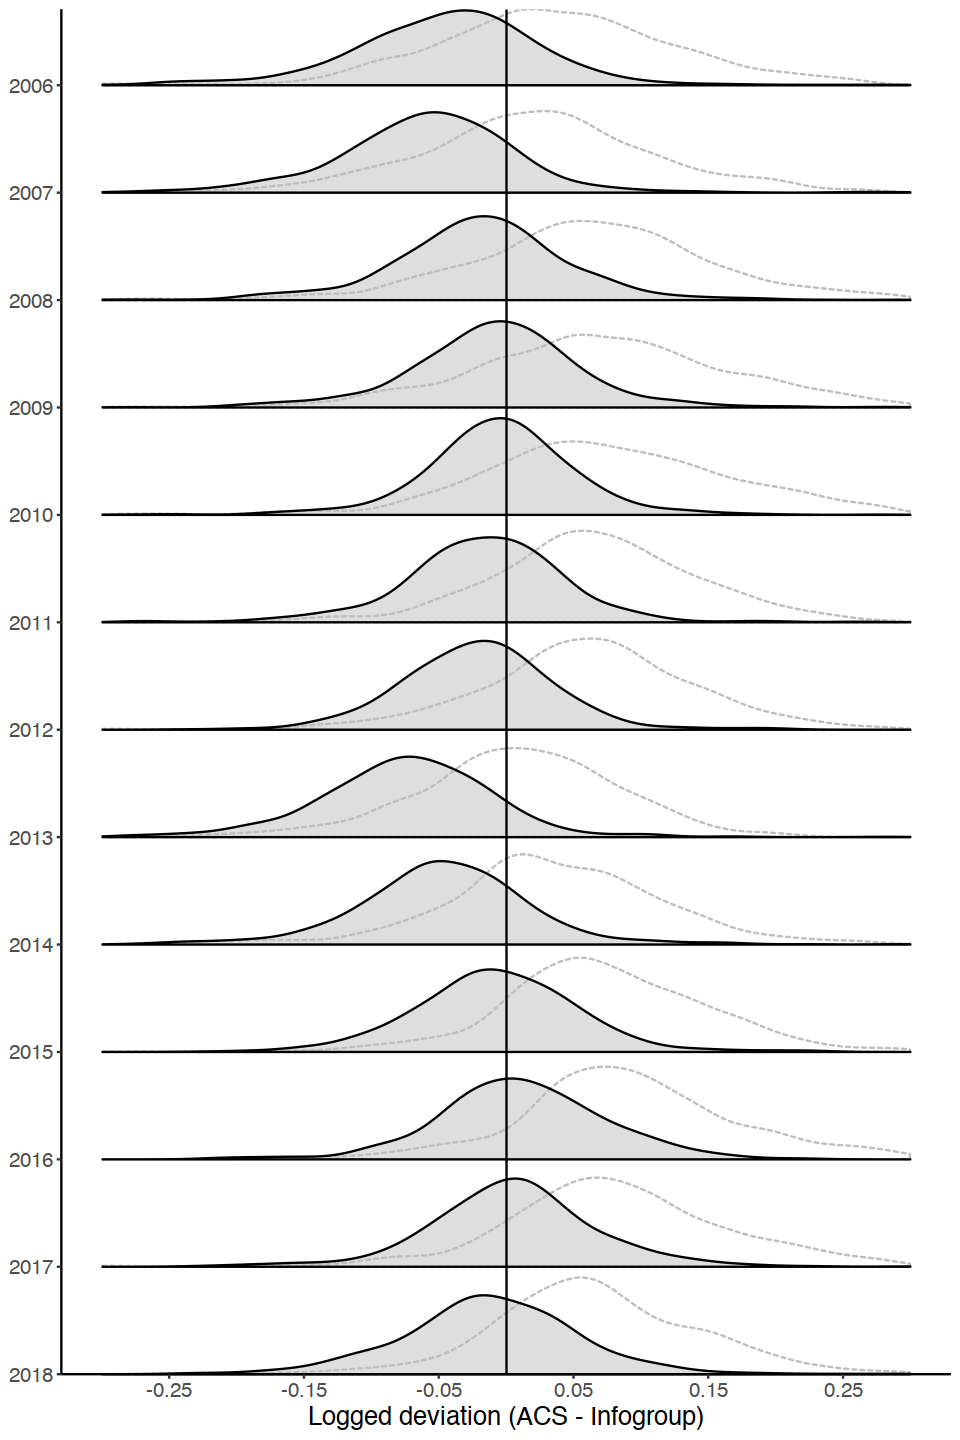

In [101]:
options(repr.plot.width=8, repr.plot.height=12)

projections %>%
    mutate(dev = log(chh) - lprd_4,
           dev2 = log(chh) - lig) %>%
    ggplot(aes(x = dev, y = fct_rev(as_factor(year)))) +
     geom_density_ridges2(
        aes(x = dev2),
        fill = NA,
        color = "grey",
        linetype = "dashed",
        panel_scaling = TRUE,
        alpha = 0.5,
        scale = .9,
        bandwidth = 0.0179
    ) +
    geom_density_ridges2(
        panel_scaling = FALSE,
        fill = "grey",
        alpha = .5,
        scale = .9,
        bandwidth = 0.0179
    ) +
    geom_vline(xintercept = 0, color = 'black', linetype = "solid") +
    scale_x_continuous(
        limits = c(-.3, .3),
        name = "Logged deviation (ACS - Infogroup)",
        breaks = seq(-.25, .25, .1)
    ) +
    scale_y_discrete(expand = c(0, 0)) +
    theme_classic() +
    theme(
        text = element_text(size = 15),
        axis.title.y = element_blank()
    )

In [102]:
ggsave("../plots/county_distributions.png", height = 8, width = 6)

Warning message:
“Removed 119 rows containing non-finite values (stat_density_ridges).”
Warning message:
“Removed 30 rows containing non-finite values (stat_density_ridges).”


#### County error band examples

In [64]:
# Get quartiles
countyid_quartile <- projections %>%
    group_by(countyid) %>%
    summarize(acs_mean = mean(log(chh))) %>%
    mutate(acs_quartile = quantcut(acs_mean, q = 4, na.rm = TRUE))
levels(countyid_quartile$acs_quartile) <- c(1, 2, 3, 4)
levels(countyid_quartile$acs_quartile)

`summarise()` ungrouping output (override with `.groups` argument)



[1] "1" "2" "3" "4"

In [80]:
# Get county names
county_names_lookup <- read_csv("../data/lookups/county_name_lookup.csv")
projections <- projections %>% 
    left_join(county_names_lookup) %>%
    mutate("countyname" = paste0(name, ", ", state))

Parsed with column specification:
cols(
  countyid = col_character(),
  name = col_character(),
  state = col_character()
)

Joining, by = c("countyid", "name", "state")



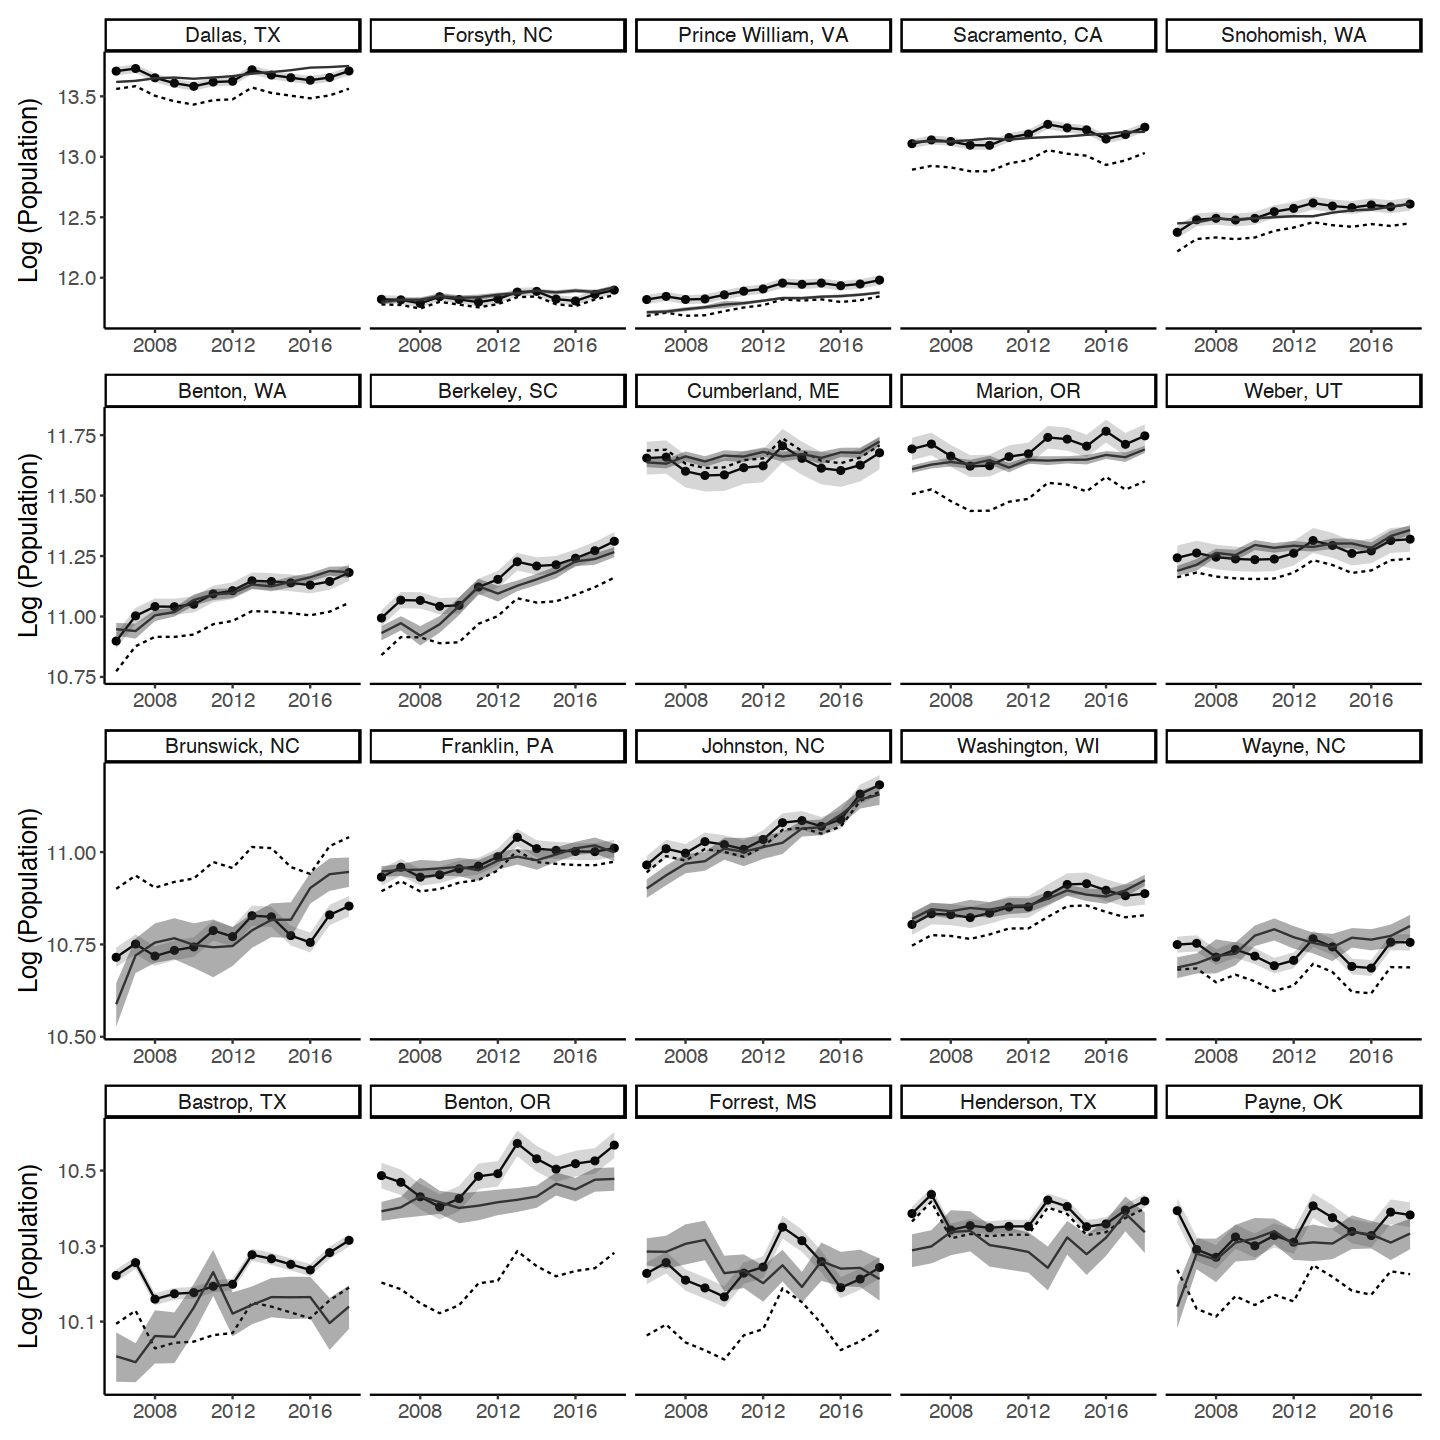

In [99]:
options(repr.plot.width=12, repr.plot.height=12)

plot_cases <- function(projections, county_sample) {
    projections %>%
    select(
        countyid, countyname, year, contains("_4"), contains("acs"), 
        ig_count_imptd, chh, lig, contains("_in_"), state
    ) %>%
    filter(countyid %in% county_sample) %>%
    ggplot() +
        geom_line(aes(x = year, y = lprd_4)) +
        geom_point(aes(x = year, y = lprd_4)) +
        geom_ribbon(
            aes(x = year, ymin = ll90_4, ymax = lu90_4),
            alpha = 0.2
        ) +
        geom_line(
            aes(x = year, y = log(ig_count_imptd)),
            linetype = 'dashed'
        ) +
        geom_line(
            aes(x = year, y = log(chh)),
            color = 'grey20'
        ) +
        geom_ribbon(
            aes(x = year, ymin = lacs_lower, ymax = lacs_upper),
            alpha = 0.4,
            fill = 'grey20'
        ) +
        facet_grid(. ~ countyname) +
        scale_y_continuous(name = "Log (Population)") +
        scale_x_continuous(breaks = seq(2008, 2016, 4)) +
    theme_classic() +
    theme(
        text = element_text(size = 15),
        axis.title.x = element_blank()
    )
}

q1_sample <- countyid_quartile %>%
    filter(acs_quartile == '1') %>%
    sample_n(5) %>%
    .$countyid %>%
    unique()
p1 <- plot_cases(projections, q1_sample) +
    ggtitle("Bottom Quartile")

q2_sample <- countyid_quartile %>%
    filter(acs_quartile == '2') %>%
    sample_n(5) %>%
    .$countyid %>%
    unique()
p2 <- plot_cases(projections, q2_sample) +
    ggtitle("Second Quartile")

q3_sample <- countyid_quartile %>%
    filter(acs_quartile == '3') %>%
    sample_n(5) %>%
    .$countyid %>%
    unique()
p3 <- plot_cases(projections, q3_sample) +
    ggtitle("Third Quartile")

q4_sample <- countyid_quartile %>%
    filter(acs_quartile == '4') %>%
    sample_n(5) %>%
    .$countyid %>%
    unique()
p4 <- plot_cases(projections, q4_sample) +
    ggtitle("Top Quartile")

p4 / p3 / p2 / p1

In [100]:
ggsave("../plots/county_random_sample.png", device = "png", height = 10, width = 10)